# Alexa, how many people have your name?

***Work in Progress***

## Introduction

- Amazon Alexa, release dates [[1](#references)]
- Baby Names, England and Wales [[2](#references)]

**Other possible Sources:**

- https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data
- https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.html
- https://www.dia.govt.nz/diawebsite.nsf/wpg_URL/Services-Births-Deaths-and-Marriages-Most-Popular-Male-and-Female-First-Names
- https://data.sa.gov.au/data/dataset/popular-baby-names

## Setup

### Imports

In [1]:
# Default
from pathlib import Path
from zipfile import ZipFile
import urllib
import datetime

# Extra
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set(style="darkgrid")

### Configuration

In [2]:
DATASETS = {
    "US": {
        "url": "https://www.ssa.gov/oact/babynames/names.zip",
        "filename": "names_us.zip",
        "release": datetime.date(2015, 6, 28),
    }
}

data_path = Path(".") / "data"

## Preparation

### Download Datasets

In [3]:
# Create target folder, if not existing
data_path.mkdir(parents=True, exist_ok=True)

# Download and store files
for name, desc in DATASETS.items():
    print(f"Downloading {name}-dataset from {desc['url']} ...")
    target_file = data_path / desc["filename"]
    if target_file.exists():
        print(f"Skipped download: {target_file} already exists.")
        continue
    urllib.request.urlretrieve(desc["url"], target_file)

print("Done.")

Skipped download: data/names_us.zip already exists.
Done.


### Prepare Dataset

In [87]:
def load_dataset(name):
    """Helper function to load dataset into dataframe.

    This also brings all datasets into the same form.

    Arguments:
        name {str} -- Short name for dataset, according to DATASETS

    Returns:
        {pd.DataFrame} -- All datasets in a single dataframe

    """
    list_dfs = []

    # Load inidvidual Datasets
    if name == "US":
        file_path = data_path / DATASETS[name]["filename"]
        with ZipFile(file_path, "r") as zip:
            files = [f for f in zip.namelist() if f.endswith(".txt")]
            for f in files:
                df = pd.read_csv(zip.open(f), names=["Name", "Gender", "Count"])
                df = df[df["Gender"] == "F"]
                df["Year"] = pd.to_datetime(int(f[3:7]), format="%Y")
                df["Dataset"] = name
                df["Rank"] = df["Count"].rank(method="max", ascending=False).astype(int)
                list_dfs.append(df)

    # Merge list of dataframes into single dataframe
    df_all = pd.concat(list_dfs, axis=0, ignore_index=True)

    return df_all


df = load_dataset("US")
df.head()

,Name,Gender,Count,Year,Dataset,Rank
0,Mary,F,7065,1880-01-01,US,1
1,Anna,F,2604,1880-01-01,US,2
2,Emma,F,2003,1880-01-01,US,3
3,Elizabeth,F,1939,1880-01-01,US,4
4,Minnie,F,1746,1880-01-01,US,5


In [88]:
# Group by dataset and year, discard gender information
df = df.groupby(["Dataset", "Year", "Name", "Rank"]).agg({"Count": sum})

# Calculate percentage of names per year
df["Percentage"] = df.groupby(level=1).apply(lambda x: 100 * x / float(x.sum()))

# Convert 'name' from multiindex to data column
df = df.reset_index()

df.head()

,Dataset,Year,Name,Rank,Count,Percentage
0,US,1880-01-01,Abbie,178,71,0.078027
1,US,1880-01-01,Abby,835,6,0.006594
2,US,1880-01-01,Abigail,517,12,0.013188
3,US,1880-01-01,Ada,33,652,0.716531
4,US,1880-01-01,Adah,332,24,0.026375


### Quick Sanity Check

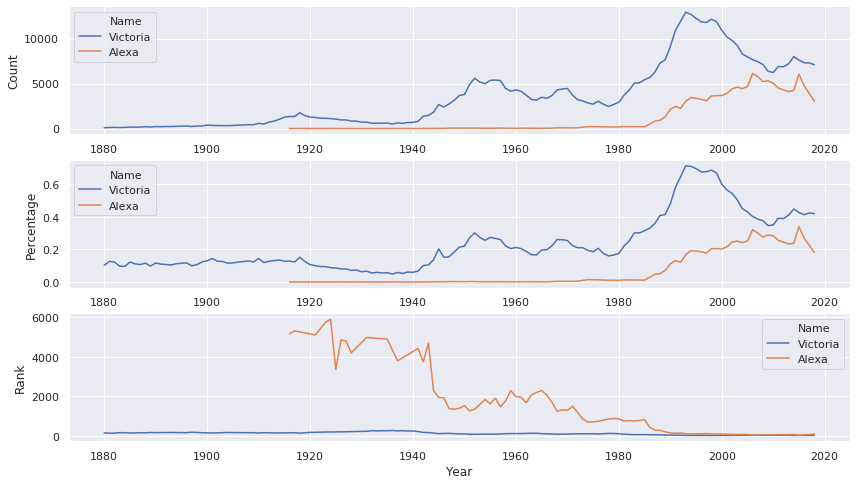

In [89]:
df_temp = df[df["Name"].isin(["Alexa", "Victoria"])]

fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sns.lineplot(x="Year", y="Count", hue="Name", data=df_temp, ax=ax[0])
sns.lineplot(x="Year", y="Percentage", hue="Name", data=df_temp, ax=ax[1])
sns.lineplot(x="Year", y="Rank", hue="Name", data=df_temp, ax=ax[2]);

## Visualization

### Filter datasets to "Alexa" only

In [93]:
df_alexa = df[df["Name"] == "Alexa"]
df_alexa = df_alexa.drop(columns="Name")
df_alexa.head()

,Dataset,Year,Rank,Count,Percentage
73595,US,1916-01-01,5162,5,0.000479
78761,US,1917-01-01,5311,5,0.000462
100991,US,1921-01-01,5098,6,0.000487
112643,US,1923-01-01,5739,5,0.000414
118386,US,1924-01-01,5899,5,0.000400


### Quick and dirty version

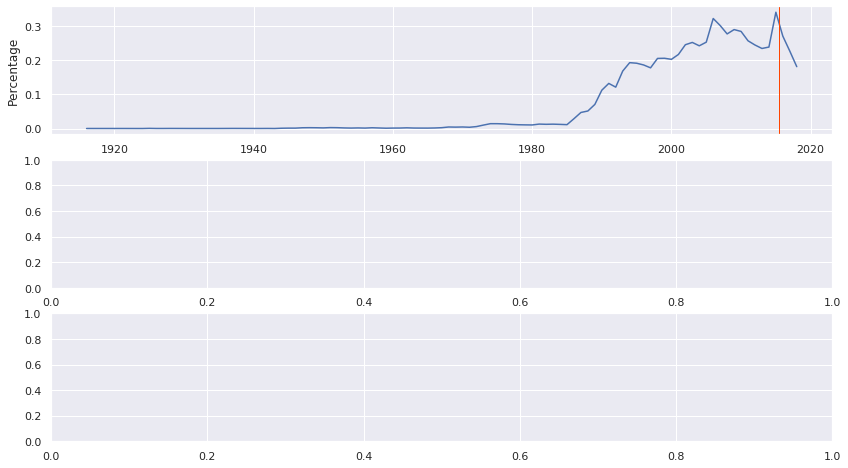

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sns.lineplot(x="Year", y="Percentage", data=df_alexa, ax=ax[0])
ax[0].axvline(x=DATASETS["US"]["release"], color="orangered", linewidth=1);

### Final Version

<a name="references" />

## References

[1] Wikipedia contributors (2019): **Amazon Alexa**. In *Wikipedia - The Free Encyclopedia*. Retrieved Dec 28, 2019, from <https://en.wikipedia.org/w/index.php?title=Amazon_Alexa&oldid=932280905>

[2] Office for National Statistics (2018): **Baby names in England and Wales: 2018**. Retrieved Dec 28, 2019, from <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/bulletins/babynamesenglandandwales/2018>